# AKADEMI - First Cohort (2025): Data Science & AI 
## Capstone Project

**Team members:**
- Alberto SYLVEUS
- Marcus Serginio INOSSAINT

**Instructor's name:**
- Wedter JEROME
- Geovany Baptista Polo LAGUERRE

# Project Title: Predicting Photovoltaic Energy Production Performance
![images](Images/solar_panel.jpg)

## Overview

We are going to perform a predictive model base on environmental and technical factors to determine the energy production performance.

Specifically, this will cover:

* Performing a train-test split to evaluate model performance on unseen data
* Applying appropriate preprocessing steps to training and test data
* Identifying overfitting and underfitting

## Business Understanding

The efficiency of photovoltaic (PV) energy production is highly dependent on multiple environmental and technical factors such as solar irradiance, temperature, humidity, wind speed, and panel configuration. Since these conditions vary daily, predicting energy output remains a challenge for both energy providers and communities that rely on solar energy.

Business Problem

Energy providers and communities often struggle to anticipate the level of solar energy production (low, medium, or high) for the next day. This uncertainty directly impacts:

- Energy storage planning: Insufficient storage allocation can lead to wasted energy on high-production days or shortages on low-production days.

- Grid balancing: Without accurate forecasts, providers may face instability in balancing supply with demand.

- Consumption management: Communities and businesses cannot optimize their energy usage schedules effectively.

Business Objective

The objective of this project is to develop a predictive model that classifies the level of PV energy production (low, medium, high) for the following day based on environmental and technical factors. This solution will enable:

- Improved forecasting for energy providers.

- Better storage and distribution management.

- More efficient grid balancing.

- Informed consumption planning for end-users.

Business Value

By improving prediction of daily PV energy production levels, the solution can:

- Reduce energy waste by aligning storage capacity with production forecasts.

- Enhance grid reliability and stability.

- Optimize operational costs for energy providers.

- Empower communities to make better decisions on energy usage, contributing to sustainable development.

### Data Understanding

We will be using the enhanced photovoltaic dataset that contents environment and technical data. It includes **721 rows** and **8 columns**, modeling the `...` based on all other numeric features of the dataset. ([dataset here](https://www.kaggle.com/datasets/ziya07/photovoltaic-plant-monitoring/data))

**Dataset features**
- Solar_Irradiance (float): The amount of solar energy received per unit area, usually measured in watts per square meter (W/m²). It directly influences how much electricity the PV panels can produce.
- Temperature (float): The ambient air temperature (°C) at the time of measurement. High temperatures can reduce PV panel efficiency, even under strong sunlight.
- Humidity (float): The percentage of moisture in the air. High humidity can reduce solar radiation reaching the panels and affect efficiency.
- Wind_Speed (float): The speed of wind (m/s) at the measurement time. Wind can cool down PV panels (helping efficiency), but very strong winds may introduce system stress.
- Panel_Angle (float): The orientation angle (in degrees) of the PV panel relative to the ground or the sun. Proper alignment improves energy capture.
  
**Targets**
- Energy_Output (float, kWh): The actual amount of electricity generated by the PV system during the measurement period, expressed in kilowatt-hours (kWh).
- Energy_Output_Class (categorical: Low, Medium, High): A classification of the Energy_Output into categories for easier prediction and planning.

#### Let's import libaries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score,
    RocCurveDisplay,
    accuracy_score
)

#### Quick EDA

In [6]:
# Load dataset
df = pd.read_csv("Data/enhanced_photovoltaic_data.csv", index_col=0)
# Preview
print(df.head())

                     Solar_Irradiance  Temperature   Humidity  Wind_Speed  \
Timestamp                                                                   
2024-01-01 00:00:00        499.632095    19.530827  70.534191   12.621713   
2024-01-01 01:00:00        960.571445    16.662407  49.937520    7.069308   
2024-01-01 02:00:00        785.595153    33.528016  88.132803   14.686574   
2024-01-01 03:00:00        678.926787    29.361828  25.943481    9.512132   
2024-01-01 04:00:00        324.814912    36.045719  72.336336    1.893971   

                     Panel_Angle  Energy_Output Energy_Output_Class  
Timestamp                                                            
2024-01-01 00:00:00     6.210683     117.090063                 Low  
2024-01-01 01:00:00    84.670607     478.957863                High  
2024-01-01 02:00:00    45.622839     190.098226                 Low  
2024-01-01 03:00:00    36.847086     503.067447                High  
2024-01-01 04:00:00    72.979072     506

In [7]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 721 entries, 2024-01-01 00:00:00 to 2024-01-31 00:00:00
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Solar_Irradiance     721 non-null    float64
 1   Temperature          721 non-null    float64
 2   Humidity             721 non-null    float64
 3   Wind_Speed           721 non-null    float64
 4   Panel_Angle          721 non-null    float64
 5   Energy_Output        721 non-null    float64
 6   Energy_Output_Class  721 non-null    object 
dtypes: float64(6), object(1)
memory usage: 45.1+ KB
None


In [8]:
# --- Missing values check ---
print("Missing values per column:")
print(df.isnull().sum())

Missing values per column:
Solar_Irradiance       0
Temperature            0
Humidity               0
Wind_Speed             0
Panel_Angle            0
Energy_Output          0
Energy_Output_Class    0
dtype: int64


In [9]:
print("\nPercentage of missing values:")
print((df.isnull().mean() * 100).round(2))


Percentage of missing values:
Solar_Irradiance       0.0
Temperature            0.0
Humidity               0.0
Wind_Speed             0.0
Panel_Angle            0.0
Energy_Output          0.0
Energy_Output_Class    0.0
dtype: float64


In [12]:
# duplicate values check
print('Duplicate values:')
print(df.duplicated().sum())

Duplicate values:
0


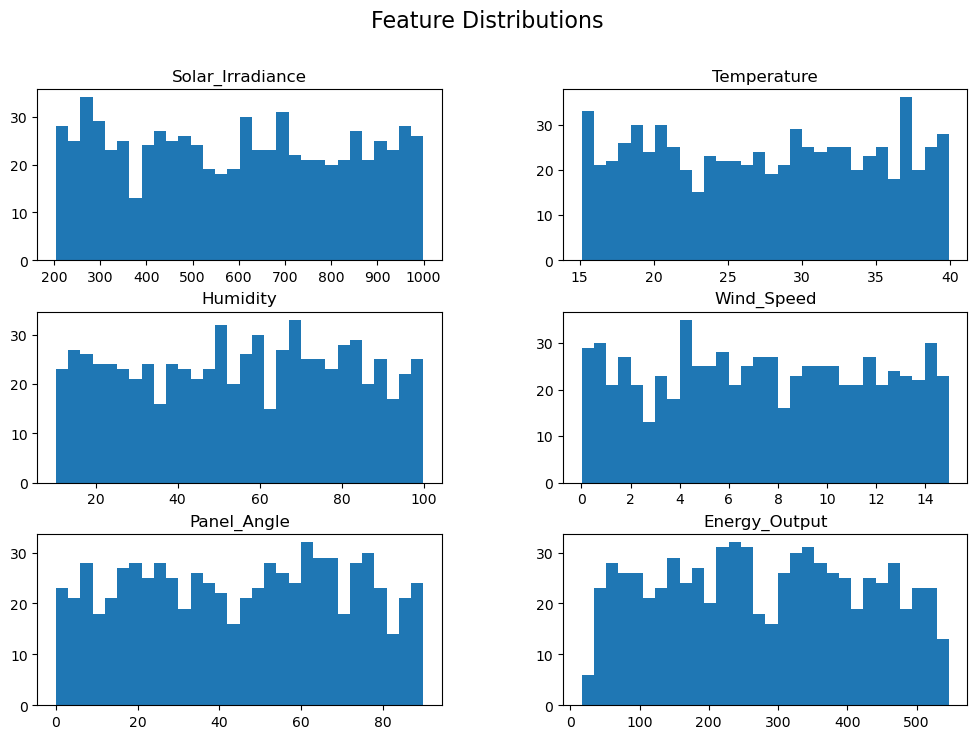

In [17]:
# plot distributions for each feature 
df.hist(bins=30, grid=False, figsize=(12, 8))
plt.suptitle("Feature Distributions", fontsize=16)
plt.show()

In [35]:
# selecting numeric columns
df_num_col = df.select_dtypes(include=['float64'])
corr = df_num_col.corr()

,Solar_Irradiance,Temperature,Humidity,Wind_Speed,Panel_Angle,Energy_Output
Solar_Irradiance,1.000000,-0.067657,0.030112,0.062226,0.041896,0.112093
Temperature,-0.067657,1.000000,0.069881,-0.014968,-0.051413,-0.037449
Humidity,0.030112,0.069881,1.000000,-0.008720,0.032810,-0.007183
Wind_Speed,0.062226,-0.014968,-0.008720,1.000000,-0.021978,-0.038990
Panel_Angle,0.041896,-0.051413,0.032810,-0.021978,1.000000,0.059182
Energy_Output,0.112093,-0.037449,-0.007183,-0.038990,0.059182,1.000000


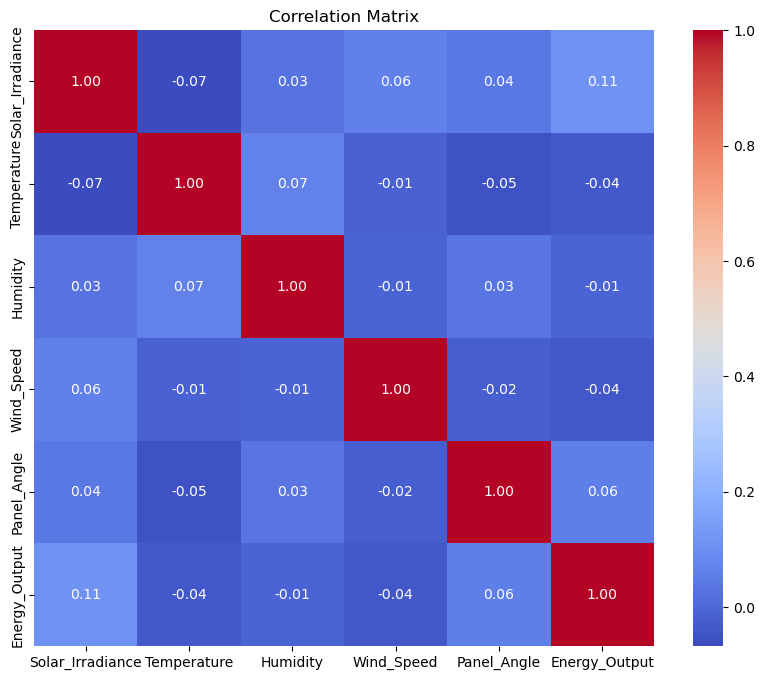

In [29]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [32]:
# check class balance in Energy_Output_Class
df['Energy_Output_Class'].value_counts(normalize=True)

Energy_Output_Class
Medium    0.414702
Low       0.331484
High      0.253814
Name: proportion, dtype: float64

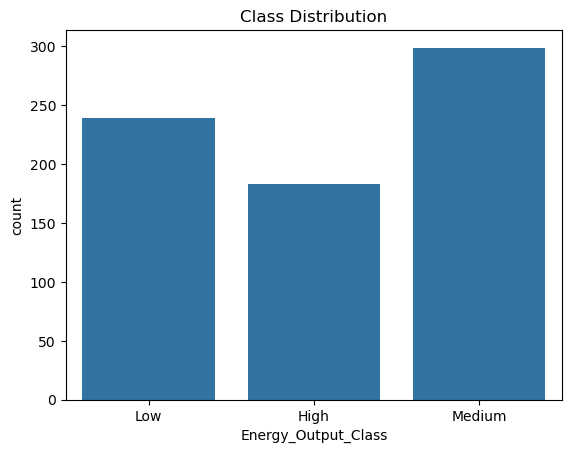

In [34]:
# visualize class distribution
sns.countplot(x='Energy_Output_Class', data=df)
plt.title("Class Distribution")
plt.show()

In [ ]:
# Encode the target vatiable

### Modeling

For the current matter we will build **two models** : 
1) A Logistic regression as the baseline model.
2) A Decision tree model as the second one, more complexe and finally tune it for more improvement.

For this reason I will first perform a **train-test split**, so that I am fitting the model using the training dataset and evaluating the model using the testing dataset.


### Requirements

#### 1. Perform a Train-Test Split

#### 2. Fit a `Logistic regression` Model

#### 3. Fit a `Decision tree` Model

#### 4. Fit a `Decision tree Tuned` Model ( Improve the previous model )

#### 5. Compare the models

#### 6. Determine feature importance

## 1. Train-Test Split


## 1. Train-Test Split


# 2. Fit a Logistic Regresssion Model

This is our baseline model. We will use StandardScaler class to scale sets data

## 3. Fit a `Decision Tree` Model



## 4. Improved Model — Hyperparameter Tuning

## 5. Model Comparison

#### Observation


## 6. Feature importance

## Business Recommendations